In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
path = '/content/drive/MyDrive/industry/demo/pose'
os.chdir(path)

!pip install alog

Mounted at /content/drive


In [3]:
from pose_estimation import pose_estimate
import cv2
from skimage import io
import numpy as np
image = io.imread('/content/drive/MyDrive/industry/demo/pose/1.PNG')
image = image/255.0

pose, colors, pairs, colors_skeleton = pose_estimate(image)
pose = pose.astype(np.int)

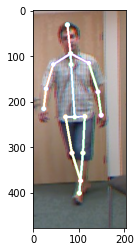

In [5]:
image = io.imread('/content/drive/MyDrive/industry/demo/pose/1.PNG')

for idx in range(len(colors)):
  cv2.circle(image, (pose[idx,0], pose[idx,1]), 3, colors[idx], thickness=3, lineType=8, shift=0)
for idx in range(len(colors_skeleton)):
  image = cv2.line(image, (pose[pairs[idx][0],0], pose[pairs[idx][0],1]), (pose[pairs[idx][1],0], pose[pairs[idx][1],1]), colors_skeleton[idx], 3)
import matplotlib.pyplot as plt
plt.subplot(1,1,1)
plt.imshow(image)
plt.savefig('test.png')

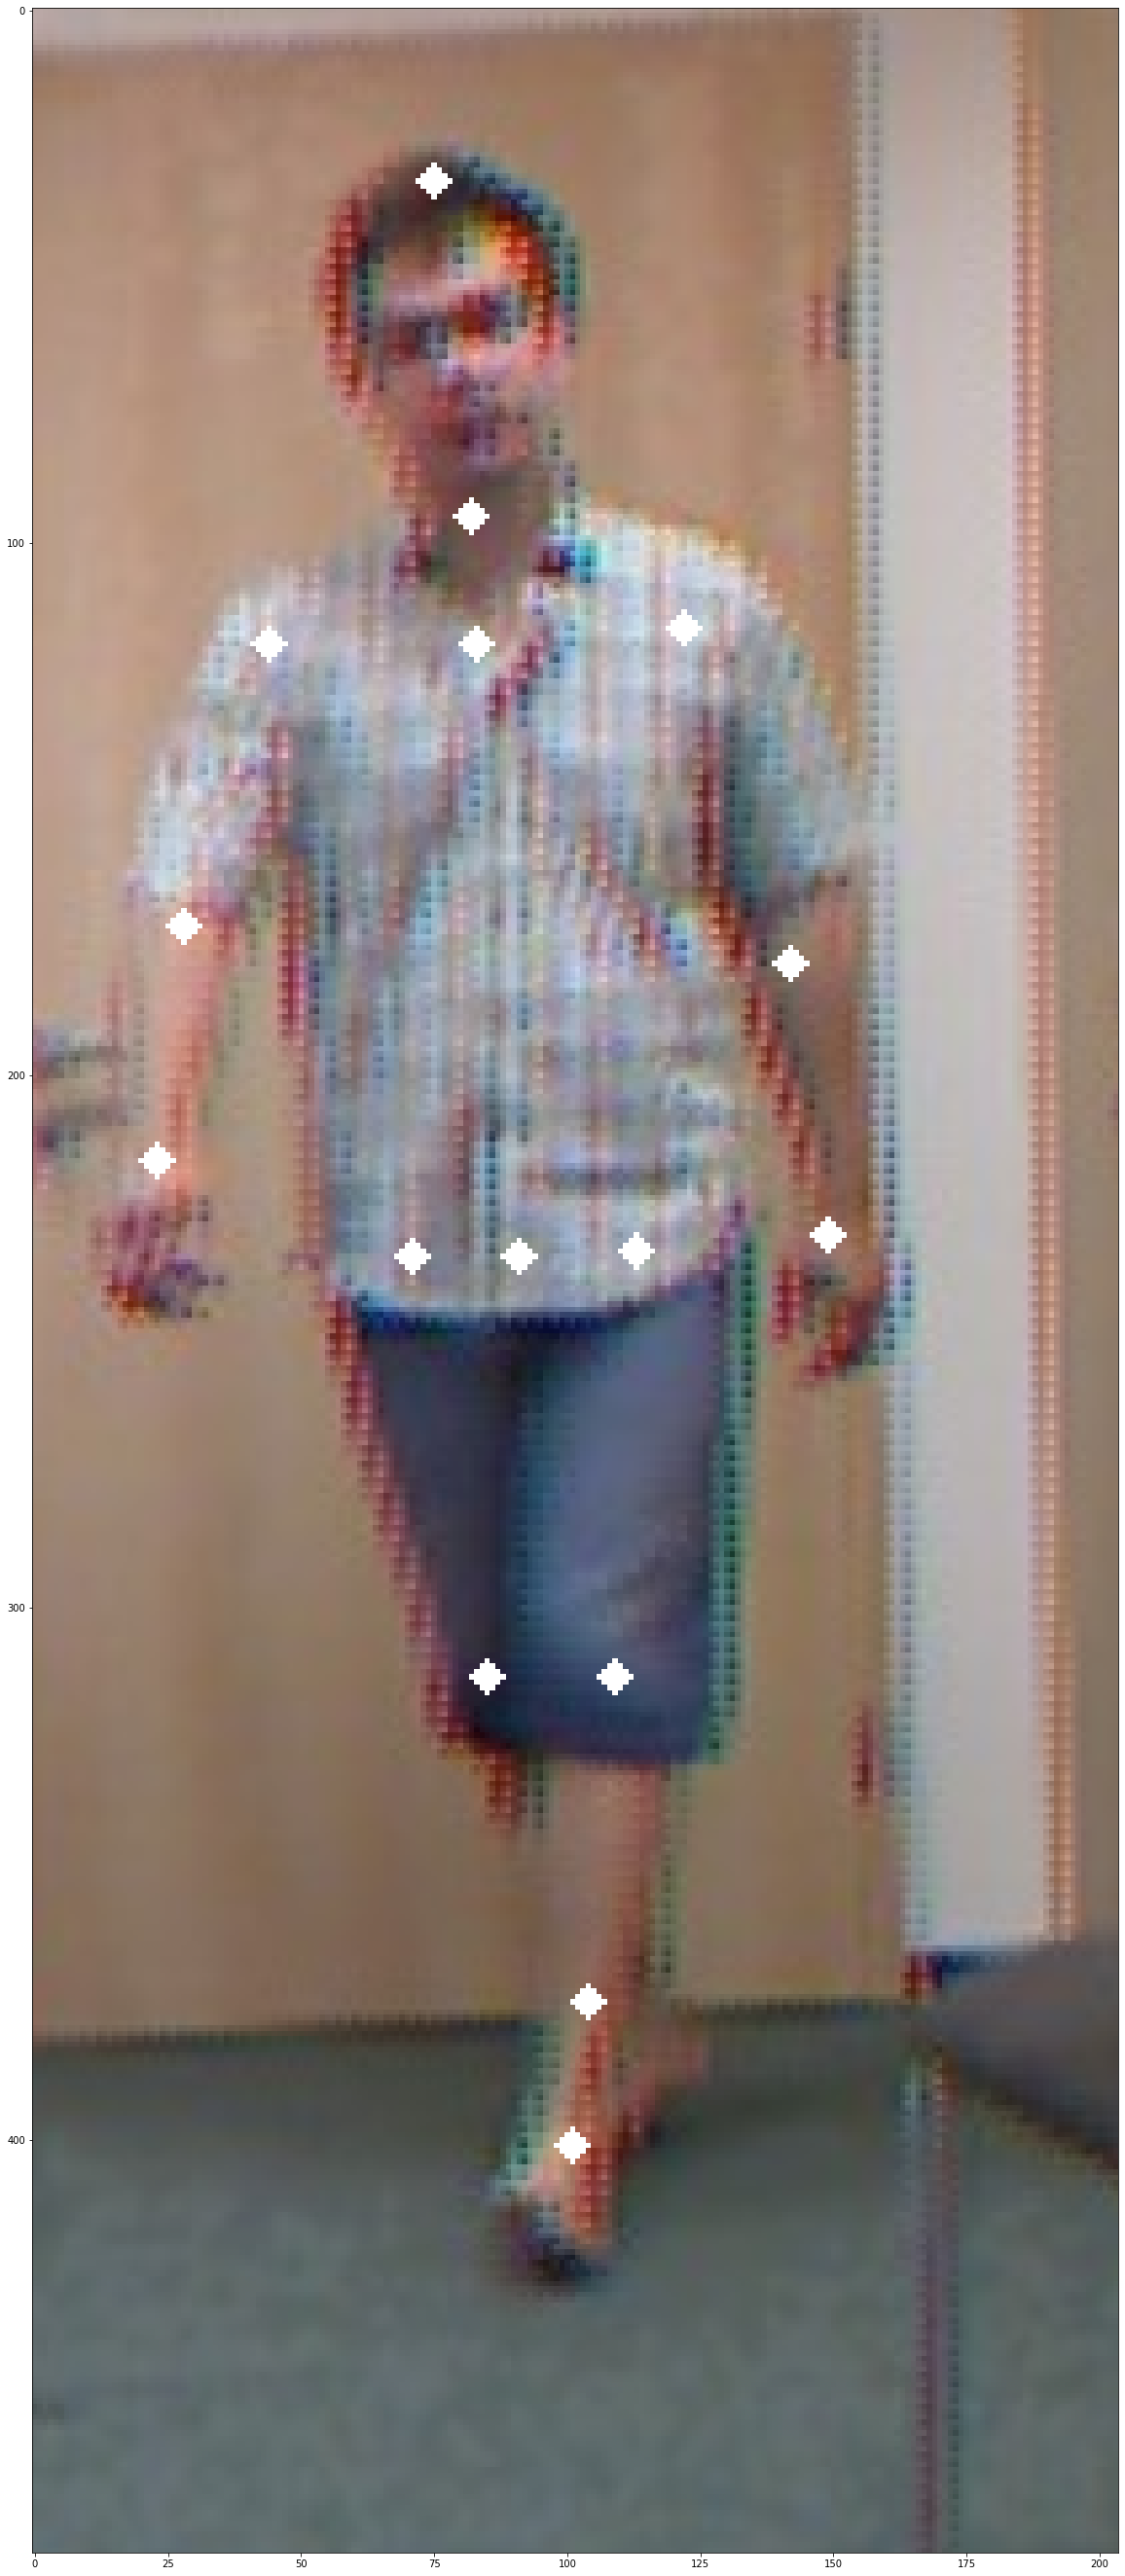

In [ ]:
point_size = 1
thickness = 4
point_color = (87,139,46)
for idx in range(len(colors)):
	cv2.circle(image, (int(pose[idx,0]), int(pose[idx,1])), point_size, (0,0,1), thickness)
plt.figure(figsize=(20,140))
plt.subplot(1,1,1)
ax = plt.gca()
plt.imshow(image)
plt.savefig('test.png')

In [ ]:
# coding: utf-8

import numpy as np
import torch
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline  

from networks import *
from network import CoordRegressionNetwork
from torch.utils.data import DataLoader
from dataset_factory import DatasetFactory, ROOT_DIR
import multiprocessing
from tqdm import tqdm

# gpu setting
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.backends.cudnn.enabled = True
device = torch.device("cuda" if True else "cpu")
num_threads = multiprocessing.cpu_count()
print("GPU NUM: %d, Thread NUM: %d"%(torch.cuda.device_count(),num_threads))

%load_ext autoreload
%autoreload 2

GPU NUM: 1, Thread NUM: 2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def expand_bbox(left, right, top, bottom, img_width, img_height):
    width = right-left
    height = bottom-top
    ratio = 0.15
    new_left = np.clip(left-ratio*width,0,img_width)
    new_right = np.clip(right+ratio*width,0,img_width)
    new_top = np.clip(top-ratio*height,0,img_height)
    new_bottom = np.clip(bottom+ratio*height,0,img_height)

    return [int(new_left), int(new_top), int(new_right), int(new_bottom)]

In [ ]:
from skimage import io
import numpy as np
import cv2

#image = io.imread('/content/drive/MyDrive/industry/MobilePose-pytorch-master/fall-01-cam0-rgb-086.png')
image = io.imread('/content/drive/MyDrive/industry/MobilePose-pytorch-master/1.PNG')
image = image/256.0

h, w = image.shape[:2]
output_size = [224, 224]
im_scale = min(float(output_size[0]) / float(h), float(output_size[1]) / float(w))
new_h = int(image.shape[0] * im_scale)
new_w = int(image.shape[1] * im_scale)
image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
left_pad = (output_size[1] - new_w) // 2
right_pad = (output_size[1] - new_w) - left_pad
top_pad = (output_size[0] - new_h) // 2
bottom_pad = (output_size[0] - new_h) - top_pad
mean=np.array([0.485, 0.456, 0.406])
pad = ((top_pad, bottom_pad), (left_pad, right_pad))
image = np.stack([np.pad(image[:,:,c], pad, mode='constant', constant_values=mean[c]) 
                        for c in range(3)], axis=2)

FileNotFoundError: ignored

In [ ]:
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
image[:,:,:3] = (image[:,:,:3]-mean)/(std)
image = torch.from_numpy(image.transpose((2, 0, 1))).float()
image = image.unsqueeze(0)

In [ ]:
modelname = "resnet18"
modelpath = "./models/%s_224_adam_best.t7"%(modelname)
inputsize = 224
net = CoordRegressionNetwork(n_locations=16, backbone=modelname).to(device)
from dataloader import display_pose
plt.figure(figsize=(20,140))

with torch.no_grad():  
  net.load_state_dict(torch.load(modelpath))
  net = net.eval()
  image = image.to(device)
  coords, heatmaps = net(image)
  print(coords.shape, heatmaps.shape)

In [ ]:
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
img = image.squeeze()
pose = coords.squeeze()
pose  = pose.data.cpu().numpy()
img = img.cpu().numpy().transpose(1,2,0)
colors = ['g', 'g', 'g', 'g', 'g', 'g', 'm', 'm', 'r', 'r', 'y', 'y', 'y', 'y','y','y']
pairs = [[8,9],[11,12],[11,10],[2,1],[1,0],[13,14],[14,15],[3,4],[4,5],[8,7],[7,6],[6,2],[6,3],[8,12],[8,13]]
colors_skeleton = ['r', 'y', 'y', 'g', 'g', 'y', 'y', 'g', 'g', 'm', 'm', 'g', 'g', 'y','y']
img = np.clip(img*std+mean, 0.0, 1.0)
img_width, img_height,_ = img.shape
pose = ((pose + 1)* np.array([img_width, img_height])-1)/2 # pose ~ [-1,1]

plt.subplot(1,1,1)
ax = plt.gca()
plt.imshow(img)
for idx in range(len(colors)):
  plt.plot(pose[idx,0], pose[idx,1], marker='o', color=colors[idx])
for idx in range(len(colors_skeleton)):
  plt.plot(pose[pairs[idx],0], pose[pairs[idx],1],color=colors_skeleton[idx])

plt.savefig('test.png')

'''
xmin = np.min(pose[:,0])
ymin = np.min(pose[:,1])
xmax = np.max(pose[:,0])
ymax = np.max(pose[:,1])

bndbox = np.array(expand_bbox(xmin, xmax, ymin, ymax, img_width, img_height))
coords = (bndbox[0], bndbox[1]), bndbox[2]-bndbox[0]+1, bndbox[3]-bndbox[1]+1
ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='yellow', linewidth=1))
'''

In [ ]:
pose = (pose - np.array([left_pad,top_pad]))/im_scale
#img = io.imread('/content/drive/MyDrive/industry/MobilePose-pytorch-master/fall-01-cam0-rgb-086.png')
img = io.imread('/content/drive/MyDrive/industry/MobilePose-pytorch-master/1.PNG')
plt.subplot(1,1,1)
ax = plt.gca()
plt.imshow(img)
for idx in range(len(colors)):
  plt.plot(pose[idx,0], pose[idx,1], marker='o', color=colors[idx])
for idx in range(len(colors_skeleton)):
  plt.plot(pose[pairs[idx],0], pose[pairs[idx],1],color=colors_skeleton[idx])

plt.savefig('test.png')